## QRISE 2024 Classiq Challenge Submission
### "The Entangled Pair" (Adam Godel and Katie Emerson)
This is our submission for Classiq's project for QRISE 2024, where we focused on creating a quantum circuit to implement the paper [Exponential Quantum Speedup in Simulating Coupled Classical Oscillators](https://journals.aps.org/prx/pdf/10.1103/PhysRevX.13.041041), specifically focusing on an implementation for the glued trees problem described in detail within that paper. We were able to implement the problem using Classiq's SDK & IDE and IBM Quantum Hardware for up to 10 qubits ($n=512$ tree columns, $N=2^{513}-2$ total nodes), however our execution results on quantum hardware were mixed.

In [1]:
from typing import cast
from classiq import *
from classiq.execution import ExecutionPreferences, IBMBackendPreferences
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
import re
import config

In this code segment below, we define a method `pauli_str` which creates the adjacency matrix used in the glued trees problem and creates a list of Pauli strings of length `dim` using Pennylane's `pauli_decompose` function that can be input into Classiq's `exponentiation_with_depth_constraint` function, simulating the unitary $e^{-iHt}$ for a Hamiltonian $H$ in the form of a Pauli list.

In the case of the glued trees problem, $\mathbf{A}$ is the weighted adjacency matrix of size $2n \times 2n$ for the glued trees reduced to columns, with the connections between the outermost columns of each tree having weight $-2$, all other connections having weight $-\sqrt{2}$, and the diagonal having weight $3$:
\begin{equation*}
\mathbf{A} = \begin{bmatrix}
3 & -\sqrt{2} & 0 & 0 & 0 & 0 & \cdots & 0 \\
-\sqrt{2} & 3 & -\sqrt{2} & 0 & 0 & 0 & \cdots & \vdots\\
\vdots & \ddots & \ddots & \ddots & 0 & 0 & \cdots & \vdots \\
0 & \cdots & -\sqrt{2} & 3 & -2 & \cdots & 0 & 0 \\
0 & 0 & \cdots & -2 & 3 & -\sqrt{2} & \cdots & 0 \\
\vdots & \cdots & 0 & 0 & \ddots & \ddots & \ddots & \vdots \\
\vdots & \cdots & 0 & 0 & 0 & -\sqrt{2} & 3 & -\sqrt{2} \\
0 & \cdots & 0 & 0 & 0 & 0 & -\sqrt{2} & 3
\end{bmatrix}
\end{equation*}
This produces a matrix of size $2n \times 2n$ where $n$ is the number of columns for each tree, or $2^q \times 2^q$ where $q$ is the length of the corresponding Pauli strings and therefore the number of qubits. This produces the relation $n=2^{q-1}$. As an example, this is the weighted adjacency matrix for $q=2$ ($n=2$):
\begin{equation*}
\mathbf{A} = \begin{bmatrix}
3 & -\sqrt{2} & 0 & 0 \\
-\sqrt{2} & 3 & -2 & 0 \\
0 & -2 & 3 & -\sqrt{2} \\
0 & 0 & -\sqrt{2} & 3
\end{bmatrix}
\end{equation*}
As shown in the paper, there is a relation $\ddot{\vec{z}}(t)=-\mathbf{A}\vec{z}(t)$, which can be modeled through Hamiltonian simulation of the matrix $H = -\sqrt{\mathbf{A}}$, resulting in the unitary $e^{i\sqrt{\mathbf{A}}t}$.

For the 2 qubit example above, this matrix $H$ produces the following Pauli list: `[('II', -1.5874077732261829), ('ZZ', -0.07592366347646495), ('XI', 0.10737227459346727), ('YY', 0.33232462698739834), ('XX', 0.36266290183459365), ('IX', 0.46997799459615847)]`.

In [2]:
CHAR_TO_STUCT_DICT = {"I": Pauli.I, "X": Pauli.X, "Y": Pauli.Y, "Z": Pauli.Z}

def pauli_str_to_enums(pauli):
    return [CHAR_TO_STUCT_DICT[s] for s in pauli]

def pauli_list_to_hamiltonian(pauli_list):
    return [
        PauliTerm(
            pauli=pauli_str_to_enums(pauli), coefficient=cast(complex, coeff).real
        )
        for pauli, coeff in pauli_list
    ]

def pauli_str(dim):
    A = [[0] * 2**dim for _ in range(2**dim)]
    for i in range(2**dim):
        if i >= 1:
            A[i][i-1] = -2 if i == 2**(dim-1) else -np.sqrt(2)
        A[i][i] = 3
        if i < 2**dim-1:
            A[i][i+1] = -2 if i == 2**(dim-1)-1 else -np.sqrt(2)
    A = -np.array(linalg.sqrtm(A))
    output = str(qml.pauli_decompose(np.array(A)))
    pauli = ["".join([j for j in i if j.isalpha()]) for i in re.findall(r'\[.*?\]', output)]
    consts = [float(i[1:-1]) for i in re.findall(r'\(.*?\)', output)]
    return [(pauli[i], consts[i]) for i in range(len(pauli))]

We began by simulating the one qubit case, by simply simulating $e^{-iYt}$ to model the relative position of one oscillator to its starting point by tracking the proportion of shots in the $\ket{1}$ state. To achieve this, we used a Classiq `qfunc` to model the exponentiation simulation of one qubit from $t=0$ to $t=2\pi$ in intervals of $\pi/16$. The function and its resulting graph are shown below.

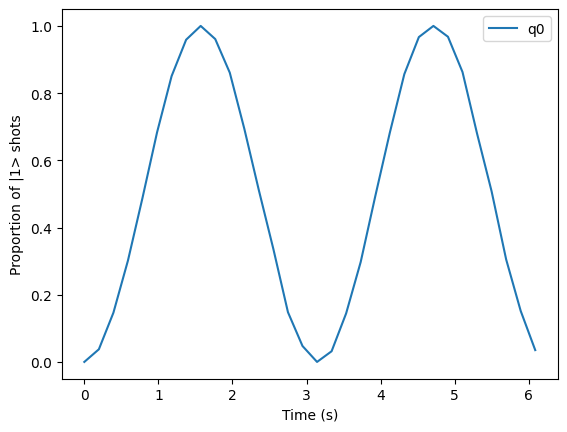

In [4]:
def one_oscillator(t):
    pauli_list=[
        ("Y", 1),
    ]
    @qfunc
    def main(state: Output[QArray[QBit]]) -> None:
        allocate(len(pauli_list[0][0]), state)
        exponentiation_with_depth_constraint(
            pauli_list_to_hamiltonian(pauli_list),
            evolution_coefficient=t,
            max_depth=400,
            qbv=state,
        )
    model = create_model(main)
    quantum_program = synthesize(model)
    job = execute(quantum_program)
    results = job.result()
    return results[0].value.counts_of_qubits(0)

times = np.arange(0, 2*np.pi, np.pi/16)
output = []
for t in times:
    try:
        output.append(one_oscillator(t)['1']/2048)
    except KeyError:
        output.append(0)
plt.plot(times, output, label='q0')

plt.xlabel("Time (s)")
plt.ylabel("Proportion of |1> shots")
plt.legend()

plt.show()

Next, we extended this to an arbitrary number of qubits. Instead of a defined Pauli list with only the $Y$ operator, we applied our `pauli_str` function described above to generate the Pauli list for the weighted adjacency matrix with Pauli strings of length `dim`. The function `n_oscillators` returns a plot of the proportion of shots of the largest qubit in the simulation of $e^{-iHt}$ from $t=0$ to $t=$`maxim` in `step` intervals.

In [13]:
def n_oscillators(dim, maxim, step):
    pauli_list = pauli_str(dim)
    def add_point(t):
        @qfunc
        def main(state: Output[QArray[QBit]]) -> None:
            allocate(len(pauli_list[0][0]), state)
            exponentiation_with_depth_constraint(
                pauli_operator=pauli_list_to_hamiltonian(pauli_list),
                evolution_coefficient=t,
                max_depth=2477,
                qbv=state,
            )
        model = create_model(main)
        quantum_program = synthesize(model)
        job = execute(quantum_program)
        results = job.result()
        return results[0].value.parsed_counts
    times = np.arange(0, maxim, step)
    output = []
    for t in times:
        point = add_point(t)
        try:
            index = [idx for idx, s in enumerate(point) if str(2**dim-1)+'.0' in str(s)][0]
            output.append(point[index].shots/2048)
        except IndexError:
            output.append(0)
    plt.plot(times, output)
    plt.xlabel("Time (s)")
    plt.ylabel("Proportion of |"+str(2**dim-1)+"> shots")
    plt.show()

This is an example of the `n_oscillators` function, simulating the proportion of $\ket{15}$ shots for 4 qubits ($n=8$) from $t=0$ to $t=24$ in 1 second intervals. Somewhat similarly to the paper's numerical simulation in Figure 4 (pg. 17), there is a significant spike at $t \approx 2n = 16$.

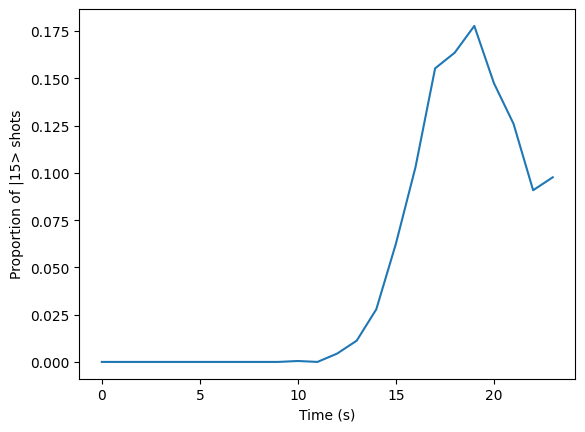

In [23]:
n_oscillators(4, 24, 1)

This is another example of the function, this time simulating the proportion of $\ket{31}$ shots for 5 qubits ($n=16$) from $t=0$ to $t=40$ in 1 second intervals. Once again, there is a spike at $t \approx 2n = 32$, and with a larger $n$ value than the previous example, the graph looks more similar to the numerical simulation in the paper.

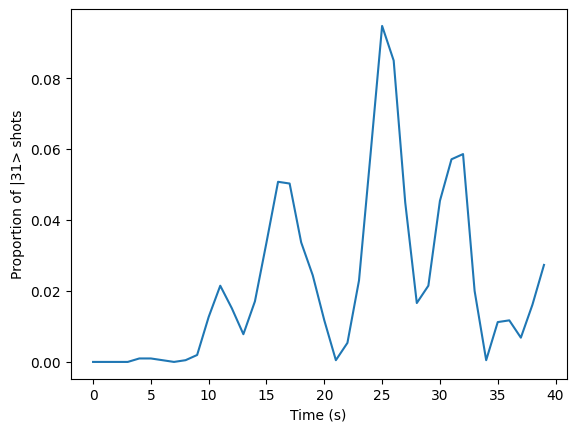

In [24]:
n_oscillators(5, 40, 1)

We decided to take these simulation results and implement them on quantum hardware as individual calls at specific times. The `sim_point` and `run_point` functions are identical, other than the fact that `sim_point` uses Classiq's Aer simulator as a way to test our expected results for small qubit values, while `run_point` executes a quantum job on IBM Brisbane hardware for `dim` qubits at time `t`. We defined our max depth as $1000($`dim`$+2)$ rather arbitrarily, but it seemed to encompass a large enough depth value for all of the quantum hardware executions we performed.

In [26]:
def sim_point(dim, t):
    pauli_list = pauli_str(dim)
    @qfunc
    def main(state: Output[QArray[QBit]]) -> None:
        allocate(len(pauli_list[0][0]), state)
        exponentiation_with_depth_constraint(
            pauli_list_to_hamiltonian(pauli_list),
            evolution_coefficient=t,
            max_depth=(dim+2)*1000,
            qbv=state,
        )
    model = create_model(main)
    quantum_program = synthesize(model)
    job = execute(quantum_program)
    results = job.result()
    return results[0].value.parsed_counts

def run_point(dim, t):
    pauli_list = pauli_str(dim)
    @qfunc
    def main(state: Output[QArray[QBit]]) -> None:
        allocate(len(pauli_list[0][0]), state)
        exponentiation_with_depth_constraint(
            pauli_list_to_hamiltonian(pauli_list),
            evolution_coefficient=t,
            max_depth=(dim+2)*1000,
            qbv=state,
        )
    preferences = IBMBackendPreferences(
        backend_name='ibm_brisbane',
        access_token=config.ibm_key,
    )
    execution_preferences = ExecutionPreferences(backend_preferences=preferences)
    model = set_execution_preferences(create_model(main), execution_preferences)
    quantum_program = synthesize(model)
    execute(quantum_program)

We decided to compare the quantum states at $t=n$ and $t=2n$ for 8 ($n=128$), 9 ($n=256$), and 10 ($n=512$) qubits. We thought this would give us enough of a time variation to investigate the change in quantum states and look for any possible spikes while still being able to compare to a fairly developed state of the simulation.

We took the data gathered by our quantum hardware executions and plotted them using Google Sheets. Our plotted results are shown in our simulation video, where we discuss them in further detail.

In [40]:
run_point(8, 2**7)
run_point(8, 2**8)
run_point(9, 2**8)
run_point(9, 2**9)
run_point(10, 2**9)
run_point(10, 2**10)

Lastly, this function takes the 6 quantum hardware executions we performed and produces their `qmod` and `qprog` files, which can be found in our challenge repository.

In [15]:
def model_point(dim, t):
    pauli_list = pauli_str(dim)
    @qfunc
    def main(state: Output[QArray[QBit]]) -> None:
        allocate(len(pauli_list[0][0]), state)
        exponentiation_with_depth_constraint(
            pauli_list_to_hamiltonian(pauli_list),
            evolution_coefficient=t,
            max_depth=(dim+2)*1000,
            qbv=state,
        )
    model = create_model(main)
    file = open(str(dim)+'_qubits_'+str(t)+'s.qmod',"w")
    file.write(model)
    file.close()
    quantum_program = synthesize(model)
    file = open(str(dim)+'_qubits_'+str(t)+'s.qprog',"w")
    file.write(quantum_program)
    file.close()

model_point(8, 2**7)
model_point(8, 2**8)
model_point(9, 2**8)
model_point(9, 2**9)
model_point(10, 2**9)
model_point(10, 2**10)

Overall, we really enjoyed this project and the opportunity to investigate this interesting physics and computer science problem using Classiq's SDK and IDE. There is certainly more to look into in this problem; we were unable to run our algorithm on quantum hardware for larger than 10 qubits, and figuring out a way to do so efficiently would be interesting. In addition, our quantum hardware execution results were mixed and investigating why or trying to run the algorithm on multiple different pieces of quantum hardware may be valuable as well. Since we are both first-year undergraduates studying computer science, we lacked a lot of the physics knowledge necessary to implement more of the paper, so we focused specifically on the glued trees problem and its implementation. 

Ultimately, we learned a lot about quantum physics and quantum computing through this opportunity, and we sincerely thank Classiq for this interesting and engaging challenge!

### Update (5/29/24)
Yesterday, we presented our project to Classiq, and discussed ways to improve our project and possibly create larger implementations of our algorithm. Currently, our primary concern is the high circuit depth of the current version of our algorithm, producing significantly noisy data. We will be looking into different approaches to minimize the circuit depth of our algorithm as well as potentially running it on quantum hardware that can accomodate higher circuit depths.

Since these efforts go beyond the scope of QRISE, we will be making a new repository where we will create a new Jupyter notebook for a more optimized version of our algorithm. We will be continuing to work with Classiq as we improve our algorithm, but this repository will remain in its current state as a record of our efforts specifically during QRISE.